In [1]:
import pandas as pa
import numpy as np
import librosa
import sqlite3
import os
from scipy import signal
from csv import reader
import matplotlib.pyplot as plt

import warnings
warnings.filterwarnings('ignore')

# Get Annotation Dictionary

In [2]:
annotation_filename = 'Annotation.csv'
def getAnnotation(annotation_filename):
    with open(annotation_filename, 'r') as read_obj:
        csv_reader = reader(read_obj)
        annotations = {}
        for row in csv_reader:
            try:
                idx = int(row[0])
            except:
                continue
            start_time_raw = row[1].split(":")
            if len(start_time_raw) == 1:
                break
            start_time_s = float(start_time_raw[0]) * 60  + float(start_time_raw[1])
            stop_time_raw = row[2].split(":")
            stop_time_s = float(stop_time_raw[0]) * 60  + float(stop_time_raw[1])

            if start_time_s == stop_time_s:
                #start_time_s = start_time_s - 1
                #stop_time_s = stop_time_s + 1
                continue

            if idx not in annotations:
                annotations[idx] = []
            category = row[3]
            annotations[idx].append([start_time_s, stop_time_s, category])
    return annotations
annotations = getAnnotation(annotation_filename)

In [3]:
x = pa.read_csv(annotation_filename)
urinate_ids  = x[x.Event == 'Urination'].iloc[:, 0].drop_duplicates().values
defecate_ids = x[x.Event == 'Defecation'].iloc[:, 0].drop_duplicates().values

# Get the Features

In [4]:
# rows:
# 1. total weight
# 2. water distance
# 3. radar sum
# 4. audio delay

In [5]:
def getTotalWeightsz(use_i):
    data_d = {}
    data_d[1] = GetSensor(use_i,1)
    data_d[2] = GetSensor(use_i,2) # seat scale
    data_d[3] = GetSensor(use_i,3) # foot scale
    clean1_sz, clean2_sz = cleanSensors(data_d[2][0],data_d[2][1],data_d[3][0],data_d[3][1])
    sumScale_sz = (clean1_sz  + clean2_sz) / 1000
    t0 = data_d[1][0][0]
    sumScale_sz.index = (sumScale_sz.index-t0)/1000 #
    return sumScale_sz

def getWaterDistancesz(use_i):
    data_d = {}
    data_d[1] = GetSensor(use_i, 1)
    t0 = data_d[1][0][0]
    data_sz = pa.Series([i*100 for i in data_d[1][1]])
    data_sz.index = [(i-t0)/1000 for i in data_d[1][0]] #
    return data_sz

def getRadarSumsz(use_i):
    data_d = {}
    data_d[1] = GetSensor(use_i,1)
    t0 = data_d[1][0][0]
    radar_df = GetRadar(use_i) 
    area_d = {}
    floor_i = 50; ceil_i = 200
    for i in radar_df.columns:
        sq_sz = (radar_df[i])**2
        area_d[i] = sum(sq_sz.iloc[floor_i:ceil_i])
    area_sz = pa.Series(area_d)
    area_sz.index = (area_sz.index-t0)/1000
    return area_sz / 1e6

def getAudioDelaysz(use_i):
    x_front, x_back = getFrontBackAudio(use_i)
    front_frames, back_frames = getFrontBackFrame(x_front, x_back)
    delay_d = getDelay(front_frames, back_frames)
    delay_sz = pa.Series(delay_d)
    filt_sz = getFilteredDelay(delay_d)
    filt_sz.index = delay_sz.index*EXAMPLE_WINDOW_SECONDS
    return filt_sz / 1e3

def getAnnotatedRegions(use_i):
    regions = annotations[use_i]
    defecate_regions = [region[:2] for region in regions if region[2] == 'Defecation']
    urinate_regions = [region[:2] for region in regions if region[2] == 'Urination']
    return urinate_regions, defecate_regions

In [6]:
def PlotWithAnnotation(use_i):
    fig, ax = plt.subplots(4, 1, figsize = (15, 2*4), sharex = True)
    featurenames = ['{} : total weight'.format(use_i), 'water distance', 'radar sum', 'audio delay']
    features = [getTotalWeightsz, getWaterDistancesz, getRadarSumsz, getAudioDelaysz]
    urinate_regions, defecate_regions = getAnnotatedRegions(use_i)
    for i, feature in enumerate(features):
        y = feature(use_i)
        ax[i].plot(y)
        ax[i].title.set_text(featurenames[i])
        if i == 0:
            ax[i].set_ylim(y.median() - 0.8, y.median() + 0.8) # total weight
        if i == 1:
            ax[i].set_ylim(12, 14) # water distance
        for urinate_region in urinate_regions:
            ax[i].axvspan(urinate_region[0], urinate_region[1]+1, alpha=0.5, color='gold')
        for defecate_region in defecate_regions:
            ax[i].axvspan(defecate_region[0], defecate_region[1]+1, alpha=0.5, color='red')
    plt.tight_layout()
    plt.show()

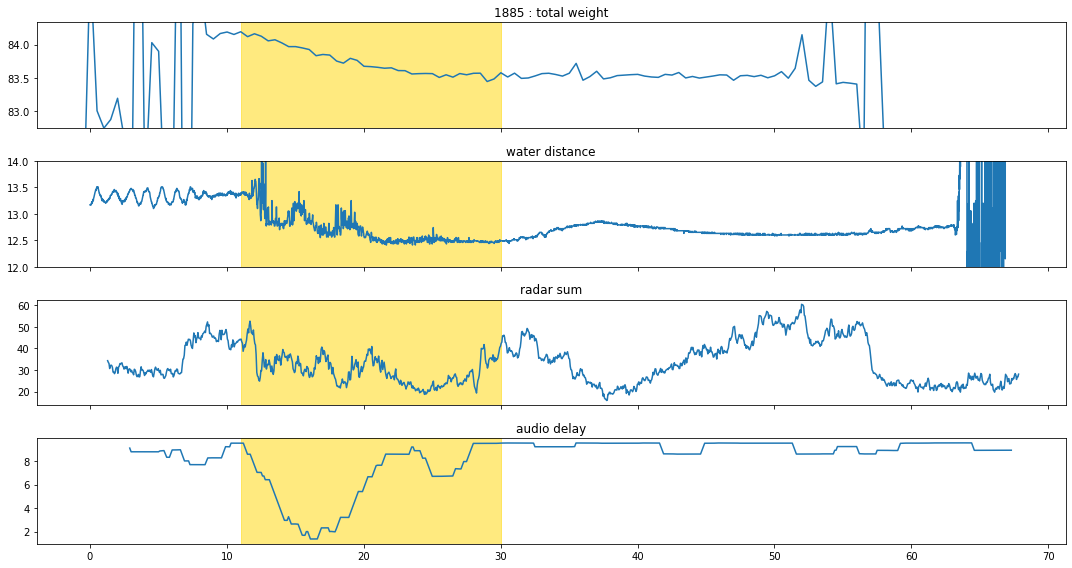

In [8]:
PlotWithAnnotation(1885)

In [9]:
def getMax(sz):
    return np.max(sz.values)

def getMin(sz):
    return np.min(sz.values)

def getMean(sz):
    return np.mean(sz.values)

def getMedian(sz):
    return np.median(sz.values)

def getVariance(sz):
    return np.var(sz.values, ddof = 1)

def getLinearTrend(sz):
    y = sz.values
    x = sz.index
    z = np.polyfit(x, y, 1)
    return z[0]

# Get Framed Features and Labels

In [10]:
# step 1: get framed time intervals

# 1.1: get start and end times
# 1.2: window_ts, hop_ts

# step 2: get framed features and labels
# 2.1: for each framed_time, locate the series
# 2.2: featureCollector
# feature dimension: ( len(framed_times) , number_of_feature_collector )

# 2.3: label
# function parameters (framed_times, annotation[use_i])
# label dimension: ( len(framed_times) , )

In [11]:
datagetter = {'TotalWeight' : getTotalWeightsz,
              'WaterDistance' : getWaterDistancesz,
              'AudioDelay' : getAudioDelaysz,
              'RadarSum' : getRadarSumsz}

featuregetter = {'Max':getMax, 'Min':getMin, 'Median':getMedian, 'Mean':getMean,
                 'Variance':getVariance, 'LinearTrend':getLinearTrend}

In [12]:
def getStartEndTime(szs):
    # szs is a list of series
    start_time = max([sz.index[0]  for sz in szs])
    end_time   = min([sz.index[-1] for sz in szs])
    return start_time, end_time

def getFramedTimes(start_time, end_time, window_ts, hop_ts):
    res = []
    t = start_time
    while t <= end_time - window_ts:
        res.append([t, t + window_ts])
        t += hop_ts
    return np.array(res)

def getFramedLabels(framed_times, annotation_times):
    res = [0] * len(framed_times)
    for idx, framed_time in enumerate(framed_times):
        for annotation_time in annotation_times:
            annotation_st, annotation_ed = annotation_time
            framed_st, framed_ed = framed_time
            if (framed_st >= annotation_st and framed_ed <= annotation_ed):
                res[idx] = 1
                break
    
    return np.array(res)

def getFramedFeaturesOneSource(sz, framed_times, feature_names, source):
    features = []
    for framed_time in framed_times:
        features_current = []
        sz_current = sz[(sz.index >= framed_time[0]) & (sz.index <= framed_time[1])]
        for feature_name in feature_names:
            features_current.append(featuregetter[feature_name](sz_current))        
        features.append(features_current)
    features = pa.DataFrame(features, columns = [source + '_' + feature_name for feature_name in feature_names])
    return features

def getFramedFeaturesSources(szs, framed_times, feature_names, sources):
    featuresAll = pa.DataFrame([])
    for sz, source in zip(szs, sources):
        featuresCurSource = getFramedFeaturesOneSource(sz, framed_times, feature_names, source)
        featuresAll = pa.concat([featuresAll, featuresCurSource], axis = 1)
    
    return featuresAll

In [13]:
def getFramedFeaturesLabelsAll(use_ids, feature_names, sources, category):
    features_all, labels_all = pa.DataFrame([]), np.array([])
    for use_i in use_ids:
        #print ("Updating user : {}".format(use_i))
        szs = [datagetter[source](use_i).dropna(axis = 0) for source in sources]
        st, ed = getStartEndTime(szs)
        framed_times = getFramedTimes(st, ed, 3, 1)
        annotated_times = [time[:2] for time in annotations[int(use_i)] if time[-1] == category]
        
        features_cur = getFramedFeaturesSources(szs, framed_times, feature_names, sources)
        labels_cur = getFramedLabels(framed_times, annotated_times)
        
        features_all = features_all.append(features_cur, ignore_index = True)
        labels_all = np.append(labels_all, labels_cur)
    
    return features_all, labels_all

In [14]:
sources = ['TotalWeight', 'WaterDistance', 'AudioDelay', 'RadarSum']
feature_names = ['Min', 'Max', 'Median', 'Mean', 'Variance', 'LinearTrend']
category = 'Urination'

# Random Forest Classifier

In [19]:
def trainTestSplit(use_ids, prop = 0.8):
    train_inds = np.random.choice(len(use_ids), int(prop * len(use_ids)), replace = False)
    train_use_ids = [use_ids[i] for i in train_inds]
    test_use_ids  = [j for j in use_ids if j not in train_use_ids]
    return train_use_ids, test_use_ids

#trainTestSplit(urinate_ids)

In [15]:
# train/test split
train_inds = np.random.choice(len(urinate_ids), int(0.8 * len(urinate_ids)), replace = False)
train_use_ids = [urinate_ids[i] for i in train_inds]
test_use_ids  = [j for j in urinate_ids if j not in train_use_ids]

# features
feature_names = ['Min', 'Max', 'Median', 'Mean', 'Variance', 'LinearTrend']
# sources
sources = ['TotalWeight', 'WaterDistance', 'AudioDelay', 'RadarSum']
# category
category = 'Urination'

In [16]:
print (urinate_ids)
print ("Training : ", len(train_use_ids))
print ("Test     : ", len(test_use_ids))

['1802' '1806' '1808' '1818' '1826' '1828' '1829' '1830' '1831' '1832'
 '1833' '1834' '1835' '1836' '1839' '1841' '1845' '1854' '1862' '1863'
 '1864' '1870' '1871' '1874' '1875' '1876' '1877' '1878' '1879' '1880'
 '1881' '1882' '1883' '1884' '1885' '1887' '1888' '1889' '1890' '1891'
 '1892' '1893' '1894' '1895' '1896' '1897' '1898']
Training :  37
Test     :  10


In [17]:
trainX, trainY = getFramedFeaturesLabelsAll(train_use_ids, feature_names, sources, category)
testX,  testY  = getFramedFeaturesLabelsAll(test_use_ids,  feature_names, sources, category)

In [20]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, plot_roc_curve

rf = RandomForestClassifier(n_estimators = 10, max_features = 15)
rf.fit(trainX, trainY)

trainYPredProb = rf.predict_proba(trainX)
testYPredProb  = rf.predict_proba(testX)

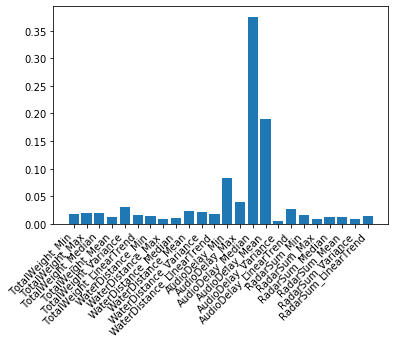

In [21]:
# variable importance
plt.bar(x = range(trainX.shape[1]), height = rf.feature_importances_)
xticks_pos = np.arange(trainX.shape[1])
plt.xticks(xticks_pos, trainX.columns, rotation=45, ha = 'right')
pass

## Overall behavior

In [22]:
testYPredProb = rf.predict_proba(testX)
testYPred = (testYPredProb[:, 1] > 0.3).astype(int)
print (classification_report(testY, testYPred))

              precision    recall  f1-score   support

         0.0       0.97      0.97      0.97       934
         1.0       0.80      0.77      0.79       133

    accuracy                           0.95      1067
   macro avg       0.89      0.87      0.88      1067
weighted avg       0.95      0.95      0.95      1067



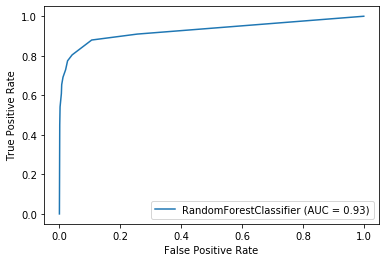

In [23]:
plot_roc_curve(rf, testX, testY);

## Individual cases

In [24]:
def booleanToRegions(labels, start_time):
    res = []
    start = 1
    while (start < len(labels)):
        while (start < len(labels) and labels[start] == 0):
            start += 1
        if (start < len(labels) - 1):
            end = start + 1
            while (end < len(labels) and labels[end] == 1):
                end += 1
            res.append([start_time + start, start_time + end - 1])
            start = end
    
    return res

def getPredictedUrinationRegions(use_i, threshold = 0.3):
    szs = [datagetter[source](use_i).dropna(axis = 0) for source in sources]
    st, ed = getStartEndTime(szs)
    framed_times = getFramedTimes(st, ed, 3, 1)
    features = getFramedFeaturesSources(szs, framed_times, feature_names, sources)
    predictions = rf.predict_proba(features)
    predictions = (predictions[:, 1] > threshold).astype(int)
    regions = booleanToRegions(predictions, st)
    return regions

In [25]:
def PlotWithAnnotationPrediction(use_i, threshold = 0.3):
    fig, ax = plt.subplots(3, 1, figsize = (15, 2*3), sharex = True)
    urinate_regions, defecate_regions = getAnnotatedRegions(use_i)
    predicted_urinate_regions = getPredictedUrinationRegions(use_i, threshold)
    totalweight = getTotalWeightsz(use_i)
    audiodelay = getAudioDelaysz(use_i)
    
    ax[0].plot(totalweight)
    ax[0].title.set_text('{} : total weight'.format(use_i))
    ax[0].set_ylim(totalweight.median() - 0.5, totalweight.median() + 0.5)
    ax[1].plot(audiodelay)
    ax[1].title.set_text('audio delay, annotated')
    ax[2].plot(audiodelay)
    ax[2].title.set_text('audio delay, predicted')

    for urinate_region in urinate_regions:
        ax[0].axvspan(urinate_region[0], urinate_region[1] + 1, alpha=0.5, color='gold')
    for urinate_region in urinate_regions:
        ax[1].axvspan(urinate_region[0], urinate_region[1] + 1, alpha=0.5, color='gold')
    for urinate_region in predicted_urinate_regions:
        ax[2].axvspan(urinate_region[0], urinate_region[1] + 1, alpha=0.5, color='red')
    
    plt.tight_layout()
    plt.savefig('evaluation/eval_withradar_{}.jpg'.format(use_i))
    plt.show()

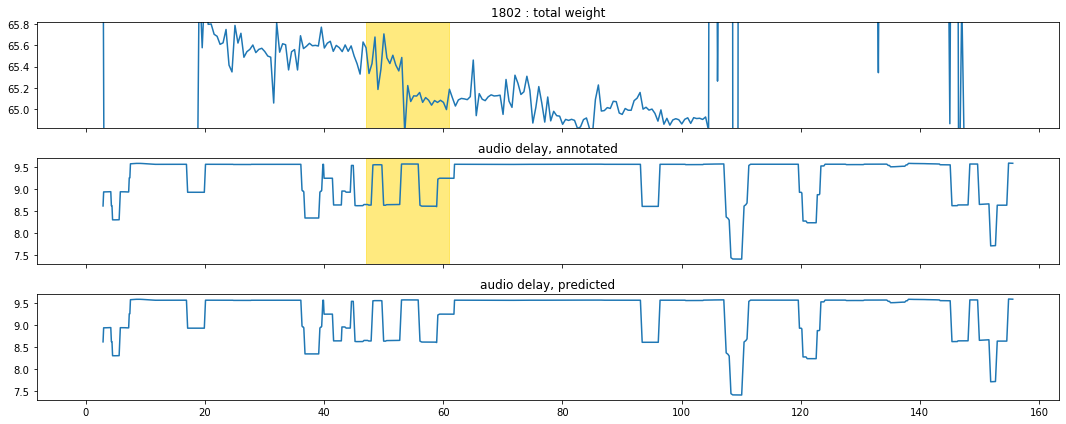

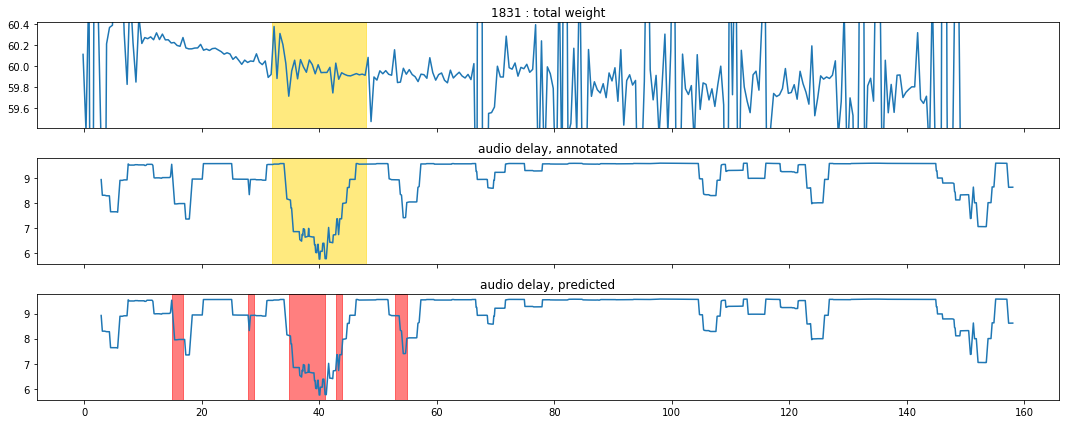

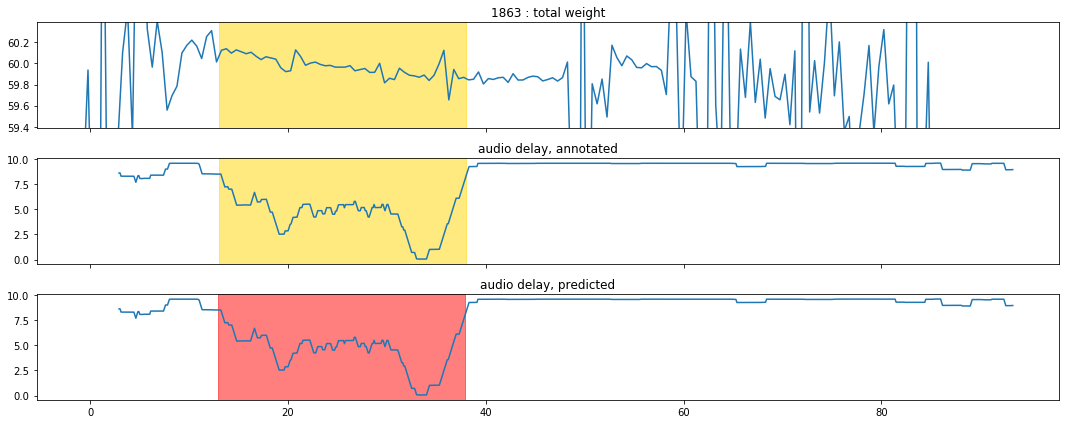

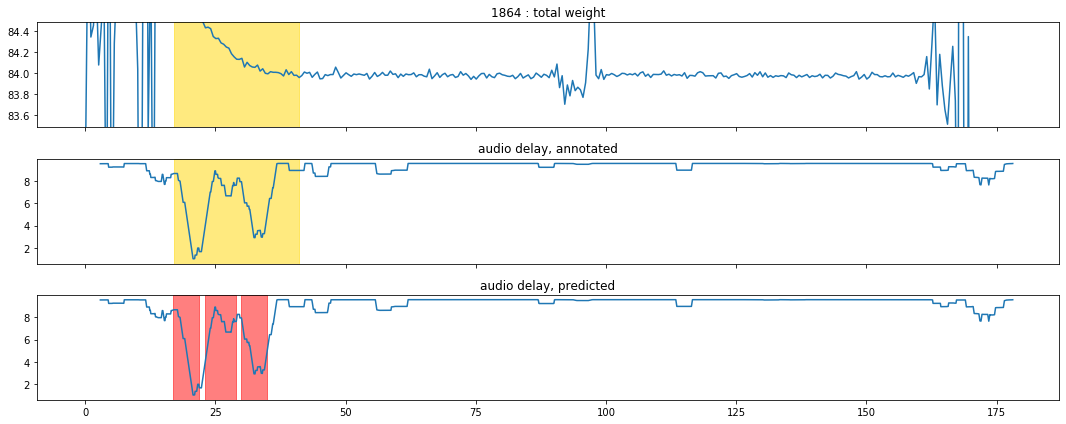

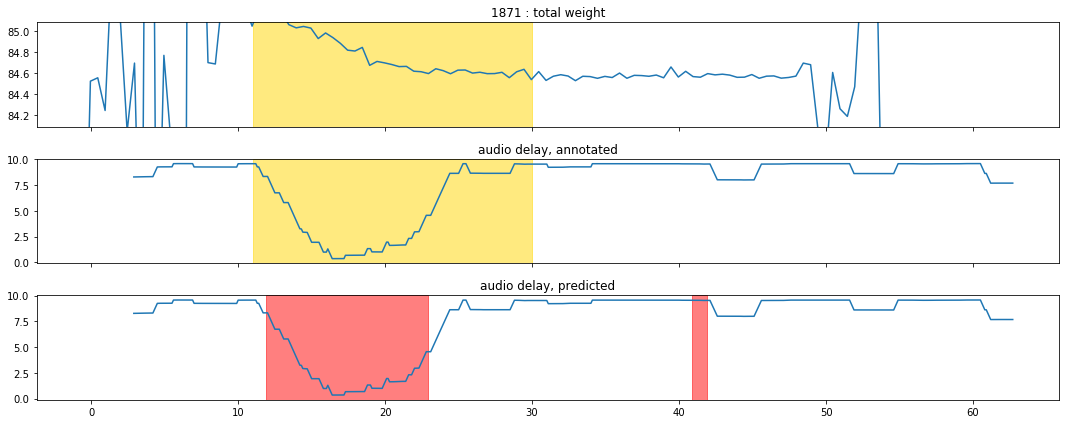

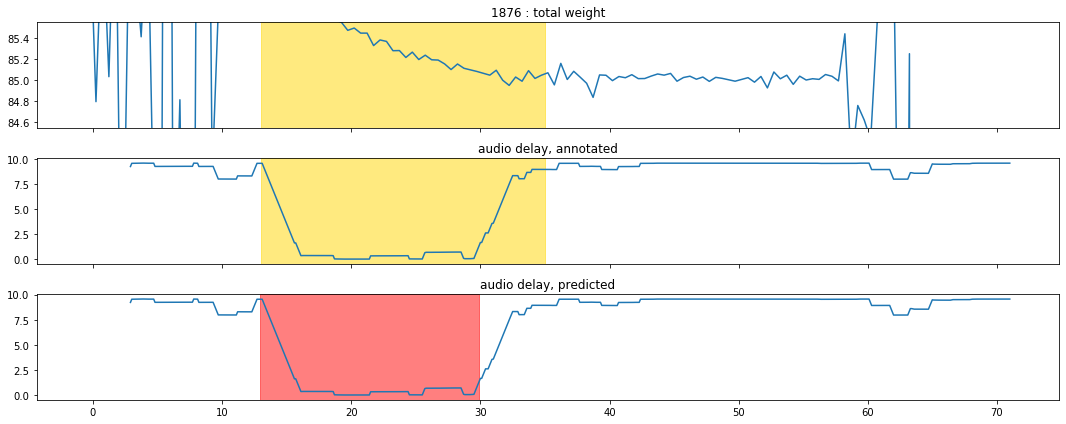

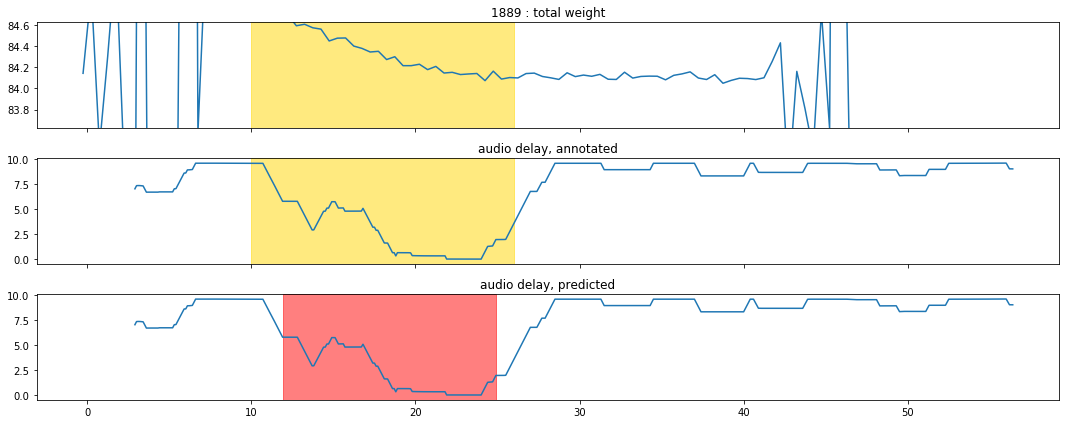

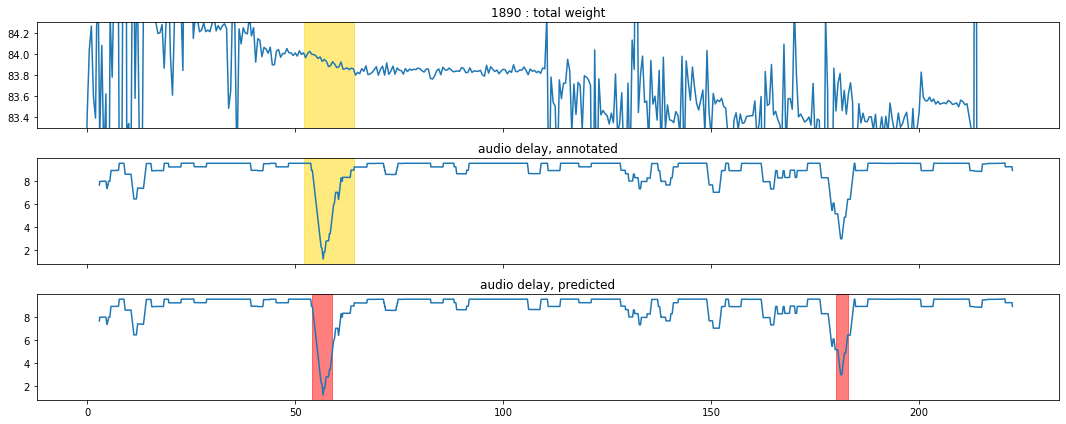

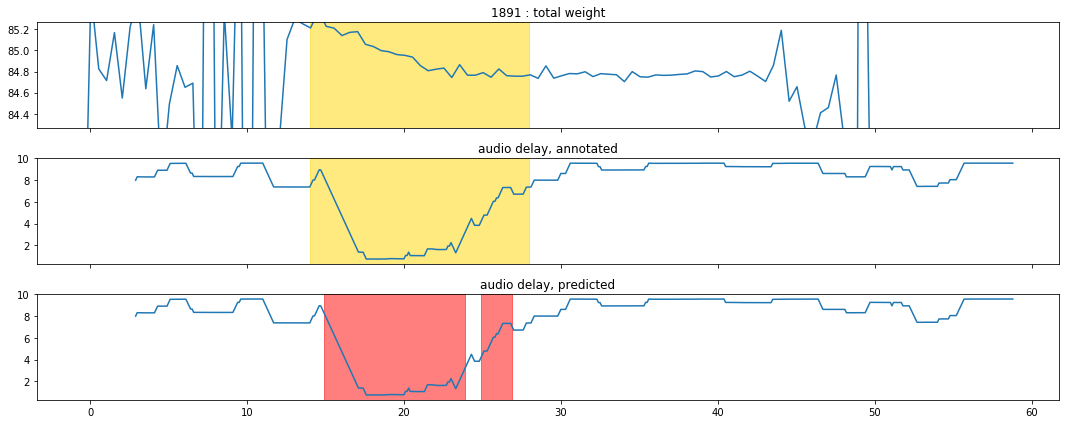

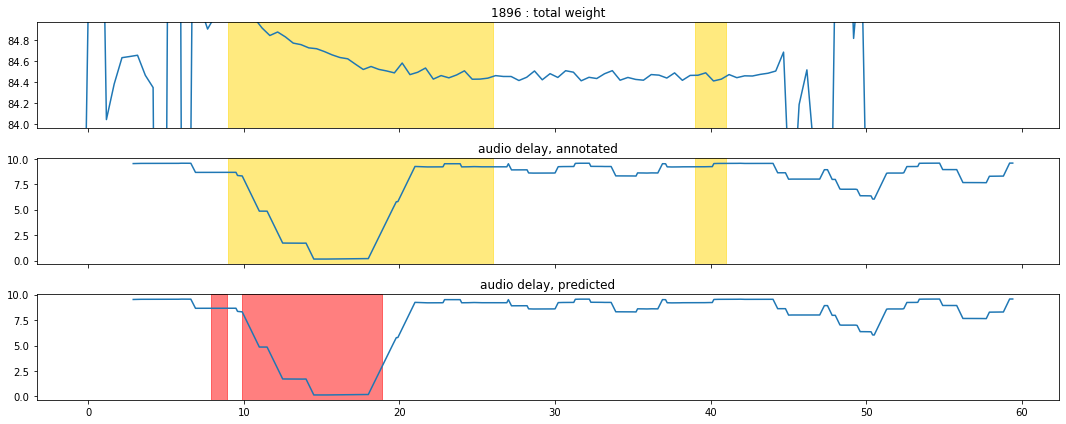

In [60]:
for use_i in test_use_ids:
    PlotWithAnnotationPrediction(int(use_i), threshold = 0.5)

# Sequence Model

In [26]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

In [27]:
class SensorDataset(torch.utils.data.Dataset):
    def __init__(self, user_ids, sources, feature_names, category):
        self.user_ids = user_ids
        self.sources = sources
        self.feature_names = feature_names
        self.category = category
        
    def __getitem__(self, index):
        user_id =int(self.user_ids[index])
        feature, label = getFramedFeaturesLabelsAll(
            [user_id],
            self.feature_names,
            self.sources, self.category
        )
        
        return torch.Tensor(feature.values).float(), torch.Tensor(label).long()
    
    def __len__(self):
        return len(self.user_ids)

In [80]:
# model
class LSTMClassifier(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim, num_layers):
        super(LSTMClassifier, self).__init__()
        self.input_dim = input_dim
        self.hidden_dim = hidden_dim
        self.output_dim = output_dim
        self.num_layers = num_layers
        
        self.lstm = nn.LSTM(
            input_size = input_dim,
            hidden_size = hidden_dim,
            num_layers = num_layers,
            bidirectional = True
        )
        self.linear = nn.Linear(hidden_dim * 2, output_dim)
        self.drop_out = nn.Dropout(0.2)

    def forward(self, x):
        # x: (length, batch_size, input_dim)
        output, _ = self.lstm(x)
        # output: (length, batch_size, hidden_dim*2)
        shape = output.shape
        output = output.view(shape[1], shape[0], shape[2])
        output = self.drop_out(output)
        # output: (batch_size, length, hidden_dim*2)
        out = self.linear(output)
        # out: (batch_size, length, output_dim)
        # the activation is included in the criterion CrossEntropy
        return out

In [29]:
train_use_ids, test_use_ids = trainTestSplit(urinate_ids)
print (len(train_use_ids), len(test_use_ids))

37 10


In [101]:
SOURCES = ['TotalWeight', 'WaterDistance', 'RadarSum', 'AudioDelay']
FEATURE_NAMES = ['Min', 'Max', 'Median', 'Mean', 'Variance', 'LinearTrend']
CATEGORY = "Urination"

USER_IDS = urinate_ids
TRAIN_IDS, TEST_IDS = trainTestSplit(USER_IDS)

dataset = {}
dataset['train'] = SensorDataset(TRAIN_IDS, SOURCES, FEATURE_NAMES, CATEGORY)
dataset['test'] = SensorDataset(TEST_IDS, SOURCES, FEATURE_NAMES, CATEGORY)
model = LSTMClassifier(input_dim = 24, hidden_dim = 32, output_dim = 2, num_layers = 1)
optimizer = optim.SGD(model.parameters(), lr = 0.1)
criterion = nn.CrossEntropyLoss(weight = torch.FloatTensor([1, 2]))

for epoch in range(3):
    print ("Epoch : {}".format(epoch))
    train(
        dataset = dataset['train'],
        batch_size = 5,
        model = model,
        optimizer = optimizer,
        criterion = criterion
    )
    
    test(
        dataset = dataset['test'],
        model = model,
        criterion = criterion
    )

Epoch : 0
Batch : 1 / Loss : 0.6828717589378357
Batch : 2 / Loss : 0.5918005108833313
Batch : 3 / Loss : 0.5364845991134644
Batch : 4 / Loss : 0.54964280128479
Batch : 5 / Loss : 0.508062481880188
Batch : 6 / Loss : 0.48883724212646484
Batch : 7 / Loss : 0.6198146939277649
Batch : 8 / Loss : 0.5562930107116699
Test loss: 0.5784799039363862
Epoch : 1
Batch : 1 / Loss : 0.6831893920898438
Batch : 2 / Loss : 0.5692423582077026
Batch : 3 / Loss : 0.4847979247570038
Batch : 4 / Loss : 0.530229926109314
Batch : 5 / Loss : 0.5010999441146851
Batch : 6 / Loss : 0.4445364475250244
Batch : 7 / Loss : 0.5979353189468384
Batch : 8 / Loss : 0.5068521499633789
Test loss: 0.5441045701503754
Epoch : 2
Batch : 1 / Loss : 0.6512767672538757
Batch : 2 / Loss : 0.5627105236053467
Batch : 3 / Loss : 0.491830438375473
Batch : 4 / Loss : 0.543953001499176
Batch : 5 / Loss : 0.48075249791145325
Batch : 6 / Loss : 0.44879961013793945
Batch : 7 / Loss : 0.6190237998962402
Batch : 8 / Loss : 0.5067503452301025
T

In [33]:
def train(dataset, batch_size, model, optimizer, criterion):
    model.train()
    numOfUsers = len(dataset)
    currentIdx = 0
    losses = []
    while currentIdx < numOfUsers:
        predictionsCurBatch, labelsCurBatch = [], []
        optimizer.zero_grad()
        for _ in range(batch_size):
            if currentIdx < numOfUsers:
                feature, label = dataset[currentIdx]
                shape = feature.shape
                predictions = model(feature.view(shape[0], 1, shape[1])).squeeze(0)  # lengths, 2
                predictionsCurBatch.append(predictions)
                labelsCurBatch.append(label)
                currentIdx += 1
            else:
                break
        predictionsCurBatch = torch.cat(predictionsCurBatch)
        labelsCurBatch = torch.cat(labelsCurBatch)
        loss = criterion(predictionsCurBatch, labelsCurBatch)

        loss.backward()
        optimizer.step()

        losses.append(loss.item())
        print ("Batch : {} / Loss : {}".format(len(losses), loss.item()))
    return losses

def test(dataset, model, criterion):
    model.eval()
    numOfUsers = len(dataset)
    losses = []
    with torch.no_grad():
        for idx in range(numOfUsers):
            feature, label = dataset[idx]
            shape = feature.shape
            predictions = model(feature.view(shape[0], 1, shape[1])).squeeze(0) 
            loss = criterion(predictions, label)
            losses.append(loss.item())
        print ("Test loss: {}".format(np.mean(losses)))
    
    return losses

In [95]:
random_idx = np.random.randint(len(dataset))

feature, label = dataset['train'][random_idx]
shape = feature.shape
prediction = model(feature.view(shape[0], 1, shape[1]))
prediction = F.sigmoid(prediction)
#prediction = prediction.squeeze(0).argmax(dim = 1)

In [100]:
predClass = (prediction.squeeze(0)[:, 1] > 0.3).long()
predClass

tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 1])

In [85]:
label

tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0])

In [78]:
pred = model(feature.view(shape[0], 1, shape[1])).squeeze(0)
nn.CrossEntropyLoss(reduction = "none")(pred, label)

tensor([0.3655, 0.3457, 0.3471, 0.3513, 0.3462, 0.3507, 0.3631, 0.3638, 0.3516,
        0.3490, 0.3591, 0.3418, 0.3463, 0.3422, 1.2311, 1.1479, 0.8902, 0.9458,
        0.9710, 0.9813, 0.8716, 0.9144, 0.9849, 0.5130, 0.5738, 0.4645, 0.4998,
        0.5017, 0.5240, 0.4830, 0.3617, 0.4206, 0.4446, 0.4812, 0.3465, 0.3514,
        0.4681, 0.5363, 0.4934, 0.3762, 0.3775, 0.3438, 0.3522, 0.3500, 0.3565,
        0.3469, 0.3435, 0.3454, 0.3396, 0.3396, 0.3367, 0.4384, 0.4584, 0.4201,
        0.3707, 0.4721, 0.4620, 0.4334, 0.4307, 0.4620, 0.4929, 0.4820],
       grad_fn=<NllLossBackward>)

In [ ]:
# https://discuss.pytorch.org/t/dealing-with-imbalanced-datasets-in-pytorch/22596/4
# handle imbalanced dataset

In [7]:
def GetSensor(use_i,sensor_i):
    sql_s = "SELECT timestamp_ms, value FROM data WHERE data_capture_id={} AND sensor_id={}".format(use_i,sensor_i)
    conn = sqlite3.connect(os.path.join('data', "toilet.db"))
    cursor = conn.execute(sql_s)
    time_measurements = []
    distance_measurements = []
    for row in cursor:
        time_measurements.append(row[0])
        distance_measurements.append(row[1])
    data_t = (time_measurements,distance_measurements)
    return data_t

def cleanSensors(sensor1_t_l,sensor1_y_l,sensor2_t_l,sensor2_y_l):
    min_t = min(min(sensor1_t_l),min(sensor2_t_l))
    max_t = max(max(sensor1_t_l),max(sensor2_t_l))

    # setup partitions
    step_t = 500
    min_floor_t = int(np.floor(min_t/step_t)*step_t)
    max_ceil_t = int(np.ceil(max_t/step_t)*step_t)
    
    step1_d = {}
    step2_d = {}
    for i in range(min_floor_t,max_ceil_t+step_t,step_t):
        step1_d[i] = []
        step2_d[i] = []
    #endfor

    # step through both and assign values to each partition
    for i in range(len(sensor1_t_l)):
        interval_t = int(np.floor(sensor1_t_l[i]/step_t)*step_t)
        step1_d[interval_t].append(sensor1_y_l[i])
    #endfor
    for i in range(len(sensor2_t_l)):
        interval_t = int(np.floor(sensor2_t_l[i]/step_t)*step_t)
        step2_d[interval_t].append(sensor2_y_l[i])
    #endfor

    # step through each partition and either take averages or set to nan
    clean1_d = {}
    for i in step1_d.keys():
        clean1_d[i] = np.mean(step1_d[i])
    #endfor
    clean1_sz = pa.Series(clean1_d)

    clean2_d = {}
    for i in step2_d.keys():
        clean2_d[i] = np.mean(step2_d[i])
    #endfor
    clean2_sz = pa.Series(clean2_d)
    return clean1_sz, clean2_sz

def GetRadar(use_i):

    #data_fn = 'data/data_frames/data_capture_{}/radar_data.txt'.format(use_i)
    data_fn = os.path.join("data", "data_frames/data_capture_{}/radar_data.txt".format(use_i))
    data_f = open(data_fn,'rt')
    line_s = data_f.read()
    data_l = eval(line_s)

    # save array of images
    t0_sz = pa.Series(data_l[0]['data'])
    data_d = {}
    for j in range(len(data_l)):
        t = data_l[j]['timestamp_ms']
        j_sz = pa.Series(data_l[j]['data'][0])
        data_d[t] = j_sz
    #endfor
    data_df = pa.DataFrame(data_d)
    return data_df

def frame(data, window_length, hop_length):
    num_samples = data.shape[0]
    num_frames = 1 + int(np.floor((num_samples - window_length) / hop_length))
    shape = (num_frames, window_length) + data.shape[1:]
    strides = (data.strides[0] * hop_length,) + data.strides
    return np.lib.stride_tricks.as_strided(data, shape=shape, strides=strides)

EXAMPLE_WINDOW_SECONDS = .1  
EXAMPLE_HOP_SECONDS = EXAMPLE_WINDOW_SECONDS     # overlap
sampleRate_n = 48000

def getFrontBackAudio(use_i):
    use_dn = "data/data_frames/data_capture_" + str(use_i)
    wav_fn = use_dn + "/audio_data.wav"
    x, fs = librosa.load(wav_fn, sr = sampleRate_n, mono = False)
    x_front, x_back = x[0], x[1]
    return x_front, x_back

def getFrontBackFrame(x_front, x_back):
    window_length = int(round(EXAMPLE_WINDOW_SECONDS * sampleRate_n))
    hop_length = int(round(EXAMPLE_HOP_SECONDS * sampleRate_n))

    back_frames = frame(x_back,window_length,hop_length)
    front_frames = frame(x_front,window_length,hop_length)
    return front_frames, back_frames

def getDelay(front_frames, back_frames):
    frame_n = back_frames.shape[0]
    delay_d = {}
    for i in range(frame_n):
        back_frame = back_frames[i,:]
        back_pad = np.concatenate((back_frame,np.zeros(back_frame.shape)),axis=0)
        front_frame = front_frames[i,:]
        front_pad = np.concatenate((front_frame,np.zeros(front_frame.shape)),axis=0)
        corr_cross = np.fft.ifft(np.fft.fft(front_pad)*np.fft.fft(back_pad[::-1]))
        corr_mag = np.abs(corr_cross)
        corr_argmax = np.argmax(corr_mag)
        delay_d[i] = corr_argmax
    return delay_d

def getFilteredDelay(delay_d):
    delay_sz = pa.Series(delay_d)
    window_size= 3
    filt_sz = pa.Series(signal.medfilt(delay_sz, window_size))
    filt_sz = pa.Series(filt_sz).rolling(window=30).mean()
    
    return filt_sz